In [1]:
from img_doc.dataset import PubLayNetDataset
from img_doc.document import Document

from img_doc.document import Document, Block
from img_doc.document.page.extractors.block_extractors import PageAndWordClassificator, BaseRandomWalkClassificator, BaseRandomDeepNodeClassificator

import numpy as np
import json
import random

import tensorflow as tf
import keras
from keras import layers
from keras.metrics import F1Score

tf.random.set_seed(22)

from time import time
import matplotlib.pyplot as plt
import os

2024-03-13 08:59:04.605517: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 08:59:04.642250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 08:59:04.642283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 08:59:04.643451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 08:59:04.649351: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 08:59:04.649778: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# pln_ds = PubLayNetDataset(r"/home/daniil/program/dataset/publaynet/", 
                          # r"/home/daniil/program/dataset/tmp_publaynet/")

pln_ds = PubLayNetDataset(r"/media/daniil/data/publaynet/", 
                           r"/media/daniil/data/tmp_publaynet/")

In [3]:
def shuffle(x_arrays, y_arrays):
    x_vec = np.concatenate(x_arrays)
    y_vec = np.concatenate(y_arrays)
    data = [(x, y) for x, y in zip(x_vec, y_vec)]
    random.shuffle(data)
    x_vec_rnd = np.array([x for x, y in data])
    y_vec_rnd = np.array([y for x, y in data])
    return x_vec_rnd, y_vec_rnd
    

def get_data(dataset, balans=True): #, batch_size=128

    X = np.array(dataset["x"])
    y = np.array(dataset["y"])
    
    keys = np.unique(y)
    Y_keys = dict()
    for i, key in enumerate(keys):
        z = np.zeros(5)
        z[i] = 1
        Y_keys[key] = z
    Y = np.array([Y_keys[yi] for yi in y])

    X_clus_list = []
    Y_clus_list = []

    for i, item in enumerate(Y_keys.keys()):
        X_clus_list.append(X[Y[:,i]==1,:])
        Y_clus_list.append(Y[Y[:,i]==1,:])
        
    if balans:
        balans_len = [len(yc) for yc in Y_clus_list]
        min_len = min(balans_len)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    val_x = []
    val_y = []
    for class_data in zip(X_clus_list, Y_clus_list):
        data = [(x, y) for x, y in zip(class_data[0], class_data[1])]
        random.shuffle(data)
        if balans:
            data = data[:min_len]
        len_data = len(data)
        len_test = round(0.2*len_data)
        len_val = round((len_data-len_test)*0.2)
        len_train = len_data - len_test - len_val
        
        train_x.append([x for x, y in data[:len_train]])
        train_y.append([y for x, y in data[:len_train]])
        
        val_x.append([x for x, y in data[len_train:len_train+len_val]])
        val_y.append([y for x, y in data[len_train:len_train+len_val]])
    
        test_x.append([x for x, y in data[-len_test:]])
        test_y.append([y for x, y in data[-len_test:]])
        
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y, Y_keys

def save_dataset(pwc, name, set_, path_dir_jsons, count_train_files=100):
    def fun_from_tmp_and_path_image(tmp_json, img_path):
        doc = Document()
        doc.set_from_path(img_path)
        doc.pages[0].set_blocks_from_dict(tmp_json["blocks"])
        doc.pages[0].set_words_from_dict(tmp_json["additional_info"]["words"])
        if "bold" in set_:
            doc.pages[0].extract_word_bold()
        for word in doc.pages[0].words:
            for block in doc.pages[0].blocks:
                if block.segment.is_intersection(word.segment):
                    block.words.append(word)
        x = []
        y = []
        for page in doc.pages:
            try:
                try:
                    x =pwc.get_block_and_page_vecs(page)
                    for block in page.blocks:
                        y.append(block.label)
                except ValueError:
                    pass #print(doc.path)
            except:
                print("file:", doc.path)
        return {"x": [xi.tolist() for xi in x], "y": y}
    
    pln_ds.create_json_from_tmps_and_images(fun_from_tmp_and_path_image, 
                                                path_dir_jsons=path_dir_jsons, 
                                                count_train_files=count_train_files,  
                                                balans = True)


In [4]:
brwc = BaseRandomWalkClassificator(conf={"properties": ["hist_ang", "hist_bold", "hist_dist", "hist_height"], "count_step":0})
# brdc = BaseRandomDeepNodeClassificator({"properties":["many_dist", "many_angle", "place_in_block", "height", "bold", "hist_dist", "hist_ang"],
#                                         "count_node":1, 
#                                         "deep":2 })
pwc = PageAndWordClassificator(brwc, conf={"properties":["place_in_page", "count_word_in_page"]})

save_dataset(pwc, name="dataset_4.json", set_=["bold"], path_dir_jsons="dataset_tmp3", count_train_files=20)

train:
file: /media/daniil/data/publaynet/train/PMC3549480_00004.jpg
file: /media/daniil/data/publaynet/train/PMC2948423_00001.jpg
file: /media/daniil/data/publaynet/train/PMC4255692_00010.jpg
file: /media/daniil/data/publaynet/train/PMC3892795_00007.jpg
file: /media/daniil/data/publaynet/train/PMC4380967_00004.jpg
file: /media/daniil/data/publaynet/train/PMC3506735_00003.jpg
file: /media/daniil/data/publaynet/train/PMC5687320_00030.jpg
file: /media/daniil/data/publaynet/train/PMC4255692_00008.jpg
file: /media/daniil/data/publaynet/train/PMC3505796_00004.jpg
file: /media/daniil/data/publaynet/train/PMC5312421_00004.jpg
file: /media/daniil/data/publaynet/train/PMC2660902_00006.jpg
file: /media/daniil/data/publaynet/train/PMC5515006_00003.jpg
file: /media/daniil/data/publaynet/train/PMC4270420_00008.jpg
file: /media/daniil/data/publaynet/train/PMC3195333_00004.jpg
file: /media/daniil/data/publaynet/train/PMC3549480_00008.jpg
file: /media/daniil/data/publaynet/train/PMC5863695_00005.jpg
f

In [5]:
def dataset_from_jsons(count_train_files, name_dir, procent = 0.1 ):
    list_labek_block_in_file = []
    base_name_file = os.path.join(name_dir, "train_") 
    for i in range(count_train_files):
        y = []
        with open(f"{base_name_file}{i}.json", "r") as f:
            rez = json.load(f)
            for doc in rez["train"]:
                y.append(doc["y"])
            list_labek_block_in_file.append(y)
    count_class = {0: 0, 1:0, 2: 0, 3: 0, 4: 0}


    for file in list_labek_block_in_file:
        for doc in file:
            for block in doc:
                count_class[block] += 1
    
    count_procent_class = dict()
    for key, item in count_class.items():
        count_procent_class[key] = round(procent * item)
    print(count_procent_class)
    
    cordinate = dict()
    for i in range(count_train_files):
        cordinate[i] = dict()
    
    count_class_finding = {0: 0, 1:0, 2: 0, 3: 0, 4: 0}
    for i, file in enumerate(list_labek_block_in_file):
        for j, doc in enumerate(file):
            for k, block in enumerate(doc):
                if count_class_finding[block] < count_procent_class[block]:
                    count_class_finding[block] += 1
                    if j in cordinate[i].keys():
                        cordinate[i][j].append(k)
                    else:
                        cordinate[i][j] = [k]
    dataset = {"x": [], "y": []}
    
    
    for key, cord in cordinate.items():
        x = []
        with open(f"{base_name_file}{key}.json", "r") as f:
            rez = json.load(f)
            for doc_i, list_block in cord.items():
                for k in list_block:
                    dataset["y"].append(rez["train"][doc_i]["y"][k])
                    x = rez["train"][doc_i]["x"][k]
                    # x = np.concatenate([x[:], x[:]])
                    dataset["x"].append(x)
    
    return dataset

In [6]:
name = "dataset_4.json"
dataset = dataset_from_jsons(procent=1.0, count_train_files=20, name_dir="dataset_tmp3")

train_x, train_y, val_x, val_y, test_x, test_y, Y_keys = get_data(dataset, balans=True)

with open(name, "w") as f:
    json.dump({"train_x": train_x.tolist(), "train_y": train_y.tolist(),
               "val_x": val_x.tolist(), "val_y": val_y.tolist(), 
               "test_x": test_x.tolist(), "test_y": test_y.tolist()}, f)
    
del train_x, train_y, val_x, val_y, test_x, test_y, Y_keys, dataset

{0: 4757, 1: 4753, 2: 4740, 3: 4794, 4: 4774}


In [8]:
name_model = "RDMdMaPHBHdHa-PLN"
with open("dataset_4.json", "r") as f:
    dataset = json.load(f)

In [9]:
print("Первый x:\n", dataset["train_x"][0])
print("Последний, x:\n", dataset["train_x"][-1])
x_len = len(dataset["train_x"][0])
print("Размер x:\t", x_len)
print("Первый y:\t", dataset["train_y"][0])
print("Последний y:\t", dataset["train_y"][0])
print("Кол-во записей:\t", len(dataset["train_x"]))

Первый x:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.5, 0.0, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.09228187919463088, 0.8639798488664987, 0.005788712011577424]
Последний, x:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.058823529411764705, 0.0, 0.0, 0.0, 0.058823529411764705, 0.7647058823529411, 0.6666666666666666, 0.3333333333333333, 1.0, 0.3333333333333333, 0.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0, 0.25806451612903225, 0.16129032258064516, 0.03225806451612903, 0.12903225806451613, 0.06451612903225806, 0.0, 0.0, 0.0967741935483871, 0.12903225806451613, 0.1935483870967742, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.08892617449664429, 0.8901660280970626, 0.019115890083632018]
Размер x:	 47
Первый y:	 [0.0, 0.0, 1.0, 0.0, 0.0]
Последний y:	 [0.0, 0.0, 1.0, 0.0, 0.0]
Кол-в

In [10]:
mega_hist = []

In [11]:
dataset["train_y"][0]

[0.0, 0.0, 1.0, 0.0, 0.0]

In [28]:
train_x, train_y, val_x, val_y, test_x, test_y = dataset["train_x"], dataset["train_y"], dataset["val_x"], dataset["val_y"], dataset["test_x"] , dataset["test_y"]
# train_x = np.array([np.concatenate([ x[-23:]]) for x in train_x])
# val_x =  np.array([np.concatenate([ x[-23:]]) for x in val_x])
# test_x = np.array([np.concatenate([ x[-23:]]) for x in test_x])

# a = np.array(train_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# train_y = a.tolist()

# a = np.array(val_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# val_y = a.tolist()

# a = np.array(test_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# test_y = a.tolist()

#batch 75 (ac:65) node 40 в конце лучше не ставить большой dropout, а перед 0.2

# for arg in args:
# hist = []
# model = keras.Sequential()

# input_len = len(train_x[0])
# output_len = 5

# list_layer = [(40, 0.1)] # len, dropout
# epochs = 30
# batch_size = 500 # 75

# model.add(layers.Dense(units=input_len, activation='relu'))
# for lay in list_layer:
#     model.add(layers.Dropout(rate=lay[1], seed=22))
#     model.add(layers.Dense(units=lay[0],  activation='relu'))
# model.add(layers.Dense(units=output_len, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy',
#             F1Score()])

  
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))
hist.append(history)

loss_and_metrics = model.evaluate(test_x, test_y, batch_size=epochs)
loss_and_metrics
mega_hist.append({"hist": hist, "loss_and_metrics": loss_and_metrics, 
                 "list_layer": list_layer, "epochs": epochs, "batch_size": batch_size })

Epoch 1/30
31/31 [==============================] - 1s 22ms/step - loss: 0.5786 - accuracy: 0.7695 - f1_score: 0.7680 - val_loss: 0.5803 - val_accuracy: 0.7633 - val_f1_score: 0.7606
Epoch 2/30
31/31 [==============================] - 0s 4ms/step - loss: 0.5786 - accuracy: 0.7669 - f1_score: 0.7653 - val_loss: 0.5805 - val_accuracy: 0.7644 - val_f1_score: 0.7613
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 0.5757 - accuracy: 0.7719 - f1_score: 0.7705 - val_loss: 0.5788 - val_accuracy: 0.7660 - val_f1_score: 0.7634
Epoch 4/30
31/31 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7715 - f1_score: 0.7699 - val_loss: 0.5782 - val_accuracy: 0.7675 - val_f1_score: 0.7647
Epoch 5/30
31/31 [==============================] - 0s 3ms/step - loss: 0.5728 - accuracy: 0.7728 - f1_score: 0.7714 - val_loss: 0.5757 - val_accuracy: 0.7681 - val_f1_score: 0.7654
Epoch 6/30
31/31 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy

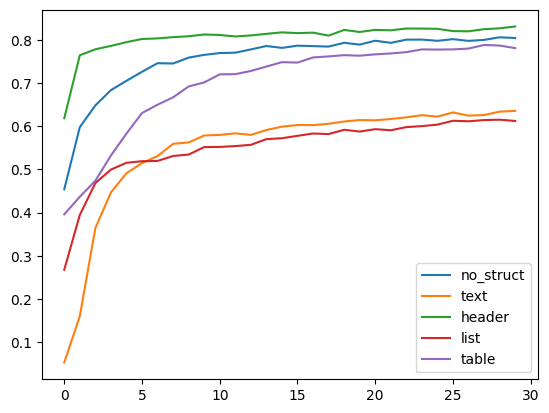

In [22]:
w = model.get_weights()
plt.plot(np.concatenate([h.history['f1_score'] for h in hist]))
plt.legend(["no_struct", "text", "header",  "list", "table"])

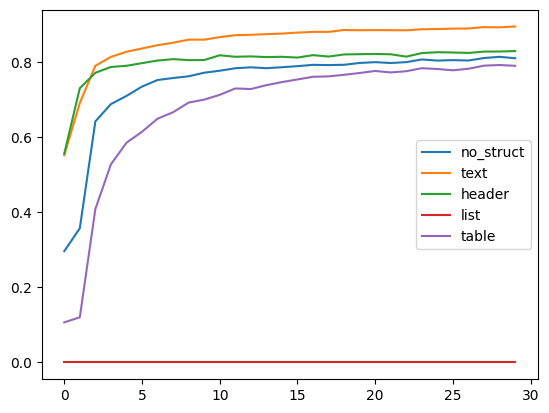

In [20]:
w = model.get_weights()
plt.plot(np.concatenate([h.history['f1_score'] for h in hist]))
plt.legend(["no_struct", "text", "header",  "list", "table"])

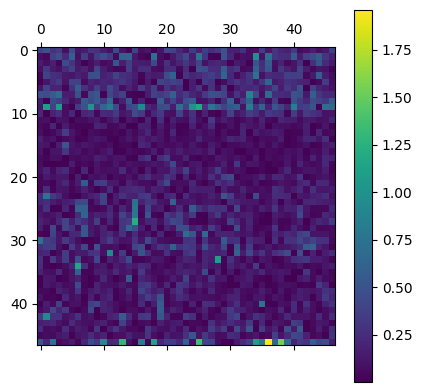

In [87]:
plt.matshow(abs(w[0]))
plt.colorbar()

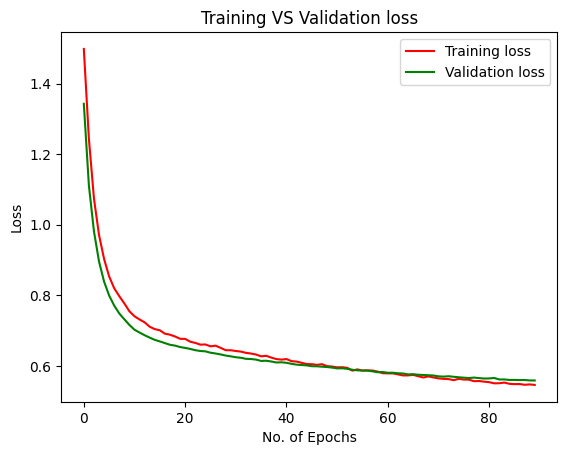

In [29]:
plt.plot(np.concatenate([h.history['loss'] for h in hist]), 'r', label='Training loss')
plt.plot(np.concatenate([h.history['val_loss'] for h in hist]), 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

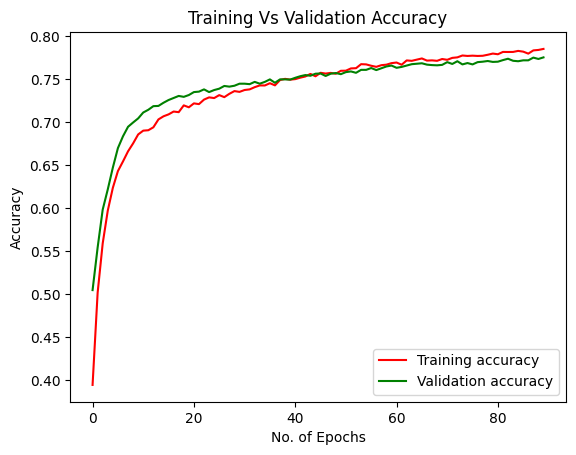

In [30]:
plt.plot(np.concatenate([h.history['accuracy'] for h in hist]), 'r', label='Training accuracy')
plt.plot(np.concatenate([h.history['val_accuracy'] for h in hist]), 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

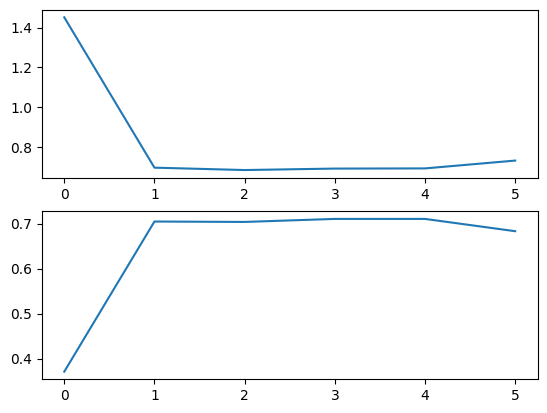

In [54]:
count_node = [0, 1, 2, 3, 4, 5]
loss = [m["loss_and_metrics"][0] for m in mega_hist[-6:]]
ac  = [m["loss_and_metrics"][1] for m in mega_hist[-6:]]
plt.subplot(2, 1, 1)
plt.plot(count_node, loss)
plt.subplot(2, 1, 2)
plt.plot(count_node, ac)


In [49]:
mega_hist[-1]

{'hist': [<keras.src.callbacks.History at 0x7f4986446440>],
 'loss_and_metrics': [0.7323734164237976, 0.6830792427062988],
 'list_layer': [(63, 0.2)],
 'epochs': 20,
 'batch_size': 1000}

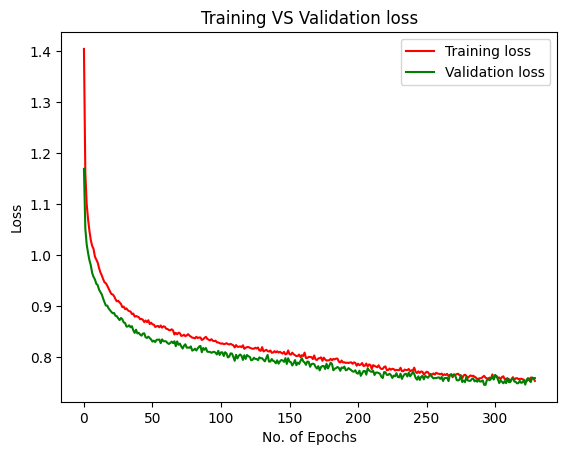

In [51]:
plt.plot(np.concatenate([h.history['loss'] for h in mega_hist[-1]["hist"]]), 'r', label='Training loss')
plt.plot(np.concatenate([h.history['val_loss'] for h in  mega_hist[-1]["hist"]]), 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

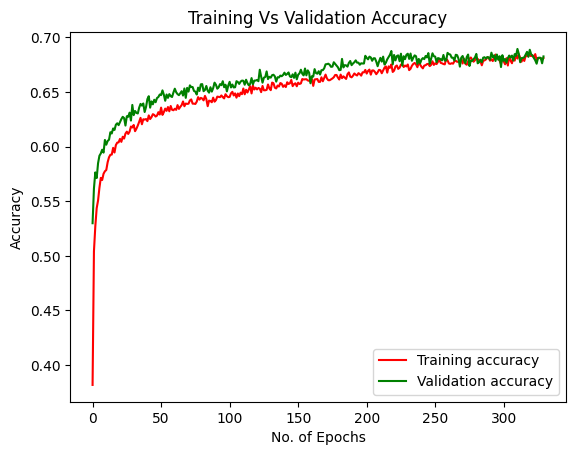

In [52]:
plt.plot(np.concatenate([h.history['accuracy'] for h in mega_hist[-1]["hist"]]), 'r', label='Training accuracy')
plt.plot(np.concatenate([h.history['val_accuracy'] for h in mega_hist[-1]["hist"]]), 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [90]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, input_len], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    print(y)
    y = self.class_pred(y)
    return y

def preprocess_test(x):
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return y

In [91]:
mlp_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [92]:
save_path = "Hdabh-PLN"
tf.saved_model.save(mlp_model_export, save_path)
mlp_loaded = tf.saved_model.load(save_path)

Tensor("sequential_4/dense_14/Softmax:0", shape=(None, 5), dtype=float32)
INFO:tensorflow:Assets written to: Hdabh-PLN/assets


INFO:tensorflow:Assets written to: Hdabh-PLN/assets


In [93]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

test_classes = mlp_loaded(test_x)
test_acc = accuracy_score([np.argmax(y) for y in test_classes], [np.argmax(y) for y in test_y])
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.855


In [41]:
test_classes

<tf.Tensor: shape=(6560, 5), dtype=float32, numpy=
array([[4.4998792e-06, 8.6203617e-01, 4.3068151e-04, 1.3705918e-01,
        4.6936882e-04],
       [1.5272138e-01, 2.4803912e-03, 4.5245327e-03, 8.1438720e-01,
        2.5886521e-02],
       [6.7259878e-04, 1.6525595e-01, 3.3556592e-02, 6.8037862e-01,
        1.2013630e-01],
       ...,
       [1.2383146e-02, 5.1072129e-04, 4.5628617e-06, 3.9627086e-03,
        9.8313886e-01],
       [4.9034823e-02, 2.2458877e-02, 9.5263160e-05, 2.9185212e-01,
        6.3655883e-01],
       [1.8309744e-04, 3.6267447e-01, 5.9808213e-01, 3.9054293e-02,
        6.0017182e-06]], dtype=float32)>

In [90]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 262.0 kB/s eta 0:00:00 MB/s eta 0:00:01
